In [1]:
#pip install yfinance
#conda install -c conda-forge voila

In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import yfinance as yf
import ipywidgets as widgets
from ipywidgets import Layout
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
np.random.seed(2021)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
#Creating the widget to let users choose from a list of stocks
unique_stock = np.array(["GOOG", "IBM", "MMM", "AMZN", "AAPL", "TSLA", "NIO", "NIU", "FSLR", "FB", "QRVO"])
stock = widgets.SelectMultiple(
    options = unique_stock.tolist(),
    value = ["GOOG"],
    description='Stock',
    disabled=False,
    layout = Layout(width='50%', height='80px', display='flex')
)
stock2 = widgets.SelectMultiple(
    options = unique_stock.tolist(),
    value = ['GOOG'],
    description='Stock2',
    disabled=False,
    layout = Layout(width='50%', height='80px', display='flex')
)

In [4]:
def rsi_cal(dta3):
    '''
    Function to calculate the Relative Strength Index for each datapoint.
    Input: a pandas dataframe
    Output: the same dataframe with an extra column with RSI values
    '''
    
    dta3['change_in_price'] = dta3['Close'].diff() #create the change in price column which calculates gains/losses

    #now we need to create an "up" and a "down" column, containing gains/losses, to calculate the Relative Strength
    up = dta3[['change_in_price']].copy()
    down = dta3[['change_in_price']].copy()

    #up only contains gains, losses are marked as 0. down only contains losses, gains are marked as 0
    for i in range(len(up['change_in_price'])):
        if up['change_in_price'][i] < 0: 
            up['change_in_price'][i] = 0
        else:
            pass

    for i in range(len(down['change_in_price'])):
        if down['change_in_price'][i] >0: 
            down['change_in_price'][i] = 0
        else:
            down['change_in_price'][i] = abs(down['change_in_price'][i]) #we want all changes to be in absolute value


    #Avoid data leakage
    df_up = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_up = df_up.append(up['change_in_price'], ignore_index=True)
    df_up.drop(df_up.tail(1).index,inplace=True)
    up['change_in_price'] = df_up
    df_down = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_down = df_down.append(down['change_in_price'], ignore_index=True)
    df_down.drop(df_down.tail(1).index,inplace=True)
    down['change_in_price'] = df_down


    # Calculate the EWMA (Exponential Weighted Moving Average)
    ewma_up = up['change_in_price'].transform(lambda x: x.ewm(span = 14).mean())
    ewma_down = down['change_in_price'].transform(lambda x: x.ewm(span = 14).mean())

    # Calculate the RS
    RS = ewma_up/ewma_down

    # Calculate the RSI
    RSI = 100.0 - (100.0 / (1.0 + RS))

    dta3['down_days'] = down['change_in_price']
    dta3['up_days'] = up['change_in_price']
    dta3['RSI'] = RSI
    #We will drop the Nas latter
    return dta3

In [5]:
def stoc_oscillator_cal(dta3):
    '''
    Function to calculate the Stochastic Oscillator for each datapoint.
    Input: a pandas dataframe
    Output: the same dataframe with an extra column with Stochastic Oscillator values
    '''
    #Creating the high and low columns
    high14 = dta3['Close'].copy()
    low14 = dta3['Close'].copy()
    close_pushed = dta3['Close'].copy()
    df_high = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_high = df_high.append(high14, ignore_index=True)
    df_high.drop(df_high.tail(1).index,inplace=True)
    high14 = df_high
    df_low = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_low = df_low.append(low14, ignore_index=True)
    df_low.drop(df_low.tail(1).index,inplace=True)
    low14 = df_low
    df_close = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_close = df_close.append(close_pushed, ignore_index=True)
    df_close.drop(df_close.tail(1).index,inplace=True)
    close_pushed = df_close


    # We use the roll function to calculate the H14 and L14
    high14 = high14.transform(lambda x: x.rolling(window = 14).max())
    low14 = low14.transform(lambda x: x.rolling(window = 14).min())

    # Calculation of Stochastic Oscillator.
    stoc_oscillator = 100 * ((close_pushed - low14) / (high14 - low14))
    dta3['low14'] = low14
    dta3['high14'] = high14
    dta3['k_percent'] = stoc_oscillator
    return dta3

In [6]:
def prc_cal(dta3):
    '''
    Function to calculate the Price Rate of Change for each datapoint.
    Input: a pandas dataframe
    Output: the same dataframe with an extra column with PRC values
    '''
    #the pct_change function helps us calculate the percentage change compared to n periods before
    close_pushed = dta3['Close'].copy()
    df_close = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_close = df_close.append(close_pushed, ignore_index=True)
    df_close.drop(df_close.tail(1).index,inplace=True)
    close_pushed = df_close
    dta3['PRC'] = close_pushed.transform(lambda x: x.pct_change(periods = 50))
    return dta3

In [7]:
def macd_cal(dta3):
    '''
    Function to calculate the Moving Average Convergence Divergence for each datapoint.
    Input: a pandas dataframe
    Output: the same dataframe with an extra column with MACD values
    '''
    #Again, push to avoid data leakage
    close_pushed = dta3['Close'].copy()
    df_close = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_close = df_close.append(close_pushed, ignore_index=True)
    df_close.drop(df_close.tail(1).index,inplace=True)
    close_pushed = df_close

    #Again, use the ewm function like above for calculating EMA of the last 26 and 12 days
    ema26 = dta3['Close'].transform(lambda x: x.ewm(span = 26).mean())
    ema12 = dta3['Close'].transform(lambda x: x.ewm(span = 12).mean())
    macd = ema12 - ema26
    #Signal line
    ema_9_macd = macd.ewm(span = 9).mean()
    dta3['MACD'] = macd
    dta3['MACD_EMA'] = ema_9_macd
    return dta3

In [8]:
def r_william_cal(dta3):
    '''
    Function to calculate the William % R for each datapoint.
    Input: a pandas dataframe
    Output: the same dataframe with an extra column with William % R values
    '''
    #Calculation process is very similar to the Stochastic Oscillator. Again, we push to avoid data leakage
    high14 = dta3['Close'].copy()
    low14 = dta3['Close'].copy()
    close_pushed = dta3['Close'].copy()
    df_high = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_high = df_high.append(high14, ignore_index=True)
    df_high.drop(df_high.tail(1).index,inplace=True)
    high14 = df_high
    df_low = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_low = df_low.append(low14, ignore_index=True)
    df_low.drop(df_low.tail(1).index,inplace=True)
    low14 = df_low
    df_close = pd.Series([np.nan]) #add one more NaN value at the beginning
    df_close = df_close.append(close_pushed, ignore_index=True)
    df_close.drop(df_close.tail(1).index,inplace=True)
    close_pushed = df_close

    # We use the roll function to calculate the H14 and L14
    high14 = high14.transform(lambda x: x.rolling(window = 14).max())
    low14 = low14.transform(lambda x: x.rolling(window = 14).min())

    # Calculate William %R 
    r_william = ((high14 - close_pushed) / (high14 - low14)) * - 100
    dta3['r_william'] = r_william
    return dta3


In [18]:
def supportvec(stock):
    '''
    Function to predict stock prices using Support Vector Regression. The function pulls stock price data from
    Yahoo Finance, then preprocess the data, and train the SVR model then predict future stock prices.
    Input: a list of stock tickers
    Output: a dictionary with results of each stock along with a graph
    '''
    results={}
    for ticker in stock:
        stock = yf.Ticker(ticker)
        # get historical market data
        dta = stock.history(period="759d") #5 years - each year has 253 trading days
        dta['Date']=dta.index
        dta.reset_index(drop=True, inplace=True)
        #Start adding the features
        dta=rsi_cal(dta)
        dta=stoc_oscillator_cal(dta)
        dta=prc_cal(dta)
        dta=macd_cal(dta)
        dta=r_william_cal(dta)
        dta=dta.dropna()
        #Training the model
        total = 759
        valid = int(total*0.2) # 20% of the data like above as test data
        train = dta.count()[0] - valid #80% of the data to train
        
        #make a copy so we leave the dta3 data set unchanged
        dta_copy = dta
        #including different features from above
        features = ['Open','RSI','k_percent', 'PRC', 'r_william', 'MACD']
        x_dta = dta_copy[features]
        y_dta = dta_copy['Close']
        x_training = x_dta[:train]
        x_val = x_dta[train:]
        y_training = y_dta[:train]
        y_val = y_dta[train:]


        #Building the model
        regr = make_pipeline(StandardScaler(), SVR(kernel = 'linear'))
        regr.fit(x_training, y_training)
        forecast_svm = regr.predict(x_val)
        real = y_dta[train:]

        
        # report performance
        rmse = math.sqrt(mean_squared_error(real, forecast_svm))
        mape = np.mean(np.abs(np.array(forecast_svm) - real)/np.abs(real))
        
        #plotting
        plt.figure(figsize = (15,10))
        plot_data = y_training.tolist() +forecast_svm.tolist()
        plt.plot(dta['Date'],plot_data)
        plt.axvline(x=dta['Date'].tolist()[train], color='red')
        plt.xlabel("Date (from red line onwards is prediction)")
        plt.ylabel("Price")
        plt.title("Predicted stock price")
        print("Root mean squared error of the model is", round(rmse, 2))
        print("Mean average percentage error of the model is", round(mape, 2))
        results[ticker]=forecast_svm.tolist()
    return results

# A simple model for portfolio optimization#

### By Hai Dang Hoang###

What is portfolio optimization? You have a few stocks in mind, and you want to allocate your money to each so that you can maximize your gains (returns), while minimizing the risk that you have to take (volatility). The concept is simple, but surprisingly difficult to execute. That is because you need to know how much gain a stock will deliver, and the risk level that comes with it, to optimize your portfolio for a future period. And if everyone knows exactly how much gain a stock delivers, we'd all be rich by now.

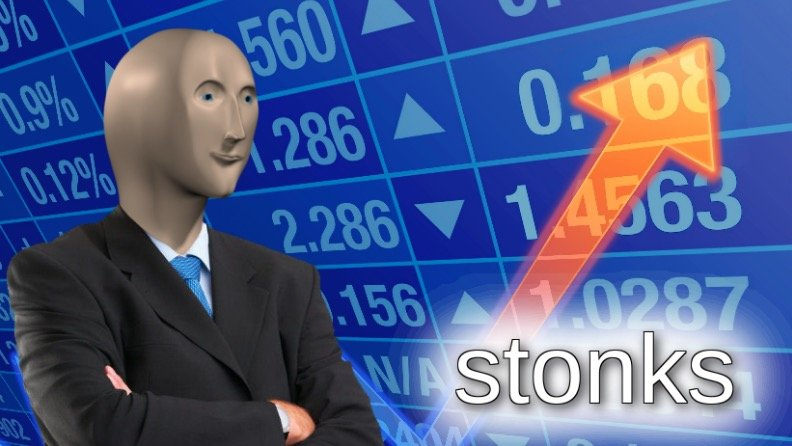

Nevertheless, that does not mean that you should not attempt to optimize our portfolio at all. Even if your predictions are off the mark, going through the process is still much better than a blind guess. For one, you are utilizing information meaningful to the stock price to make your decision - such as its past performance, its business trajectory, and so on. And secondly, it encourages you to diversify your portfolio, which reduces the risk of losing everything in one go.

The following model is a stab at doing so. There are two parts to this: 

1. A quantitative, data-based model along with the optimization results. This is presented right below in this dashboard with a few interactive options for you to tinker with. It outputs the exact results for stock prices and volatilities to feed into the optimization, and lets you know how much of your capital you should put in each stock.

2. A more qualitative, financial model. Now why would you need this, if you already have the results from the model above? The answer is you should never invest in a stock just because its past data look good. You need to understand the company - is it a strong company? Is it profitable? Are its businesses promising? This both adds a more in-depth perspective to your investment decision, and acts as a sanity check for the results of the quantitative model above. Here is the link to an example model.

### Disclaimer ###

The models presented below (as well as the linked financial models) are purely for educational purposes - the overarching aim is to familiarize readers with the concepts of equity modeling, optimization, along with other concepts in investments. Therefore, the outputs of the model must not be interpreted as an investment recommendation in any way. To prevent this, I have made the output of the stock price prediction model below to be strictly past data (meaning that a part of past data is taken out as test data to predict). The effect is twofold: since it does not predict the future, its conclusions cannot be used. Second, doing this allows us to examine the model's accuracy as we have actual data to compare against.



#### Important note ####

Before we begin, note that this Dashboard is a part of a larger project of mine aimed at providing an educational experience to investing and portfolio optimization. You can refer to the project here: 

https://danghoang-57197.medium.com/master-article-portfolio-optimization-1f708c3ddfad

This master article also links to other articles providing further explanation on this dashboard, which are the Optimization overview article, and the Technical model article.

## Part 1: A stock price prediction model ##

The following graph shows the results of our stock prediction model. As you choose one stock in the list, the model grabs 3 years' worth of past data, up until the present, of that stock from Yahoo Finance. It preprocesses the data to calculate numerous price indicators, splits the data into a training set (used to train the model) and the test set (used to test the model's predictions against). 

Data points after the red line (roughly 300 trading days) are the "predictions" - the accuracy of the model is also provided. Please refer to the Technical model article (linked above) for a more detailed explanation of the model's mechanism, as well as how to build and tweak different parameters.

Note that only a randomly selected number of stocks are provided for illustrative purposes.

#### Interpretation of the results ####

Regarding the plot, interpretation is simple - the plot shows stock prices (y axis) at given points in time (x axis). As for the errors, Root mean squared error (RMSE) represents how much our prediction strays from the real value in either direction in terms of absolute values, and Mean average percentage error (MAPE) represents, in percentage, how much our prediction strays from the real value. 

To provide a point of comparison, one of the models with the highest accuracy I found is the LSTM implementation by Ding & Qin (2019), which has an average MAPE of 0.05.

The implementation of the following model is based on the tutorial from Sigma Coding (2019).

Sigma Coding. (2019, December 19). Predicting stock price movement with random forests | introduction. Retrieved March 20, 2021, from https://www.youtube.com/watch?v=V8jZuOtckn8

In [19]:
widgets.interactive(supportvec, stock=stock)

interactive(children=(SelectMultiple(description='Stock', index=(0,), layout=Layout(display='flex', height='80…

In [11]:
def supportvec_nographs(stock):
    '''
    Function to predict stock prices using Support Vector Regression. The function pulls stock price data from
    Yahoo Finance, then preprocess the data, and train the SVR model then predict future stock prices.
    Input: a list of stock tickers
    Output: a dictionary with results of each stock along with a graph
    '''
    results={}
    for ticker in stock:
        stock = yf.Ticker(ticker)
        # get historical market data
        dta = stock.history(period="759d") #5 years - each year has 253 trading days
        dta['Date']=dta.index
        dta.reset_index(drop=True, inplace=True)
        #Start adding the features
        dta=rsi_cal(dta)
        dta=stoc_oscillator_cal(dta)
        dta=prc_cal(dta)
        dta=macd_cal(dta)
        dta=r_william_cal(dta)
        dta=dta.dropna()
        #Training the model
        total = 759
        valid = int(total*0.2) # 20% of the data like above as test data
        train = dta.count()[0] - valid #80% of the data to train
        
        #make a copy so we leave the dta3 data set unchanged
        dta_copy = dta
        #including different features from above
        features = ['Open','RSI','k_percent', 'PRC', 'r_william', 'MACD']
        x_dta = dta_copy[features]
        y_dta = dta_copy['Close']
        x_training = x_dta[:train]
        x_val = x_dta[train:]
        y_training = y_dta[:train]
        y_val = y_dta[train:]


        #Building the model
        regr = make_pipeline(StandardScaler(), SVR(kernel = 'linear'))
        regr.fit(x_training, y_training)
        forecast_svm = regr.predict(x_val)
        real = y_dta[train:]

        
        # report performance
        rmse = math.sqrt(mean_squared_error(real, forecast_svm))
        mape = np.mean(np.abs(np.array(forecast_svm) - real)/np.abs(real))

        results[ticker]=forecast_svm.tolist()
    return results

In [12]:
def annualise(allocation, mean_returns, covariance):
    """Function to annualise the standard deviation and return of each portfolio

    Parameters
    ----------
    allocation
        The weight given to each stock in the portfolio
    mean_returns
        The mean return of each stock in the portfolio
    covariance
        The covariance matrix of the stocks in the portfolio
    
    Returns
    -------
    std_annual
        annualised standard deviation
    return_annual
        annualised return

    """
    std_annual = np.sqrt(np.dot(allocation.T, np.dot(covariance, allocation))) * np.sqrt(252)
    return_annual = np.sum(mean_returns*allocation ) *252 #252 trading days per year
    return std_annual, return_annual

In [23]:
def create_random_portfolios(df, mean_returns, covariance, risk_free_rate):
    """Function to create 30000 random portfolios using the above stocks for the efficient frontier.

    Parameters
    ----------
    mean_returns
        The mean return of each stock in the portfolio
    covariance
        The covariance matrix of the stocks in the portfolio
    risk_free_rate
        Current risk-free rate. We want to invest the cash portion of the portfolio in risk-free treasury
    
    Returns
    -------
    results
        list of standard deviation, return and Sharpe ratio of each portfolio
    list_weights
        list of portfolios

    """
    list_weights = []
    results = np.zeros((3,10000)) #10000 portfolios
    for i in range(10000):
        allocation = np.random.random(len(df.columns)) #randoming the allocation 
        allocation = allocation/sum(allocation) #normalizing the randomed vectors so they sum to 1
        list_weights.append(allocation)
        std_dev = annualise(allocation, mean_returns, covariance)[0] #annualise the std and return of the portfolio
        returns = annualise(allocation, mean_returns, covariance)[1]
        results[0,i] = std_dev  
        results[1,i] = returns 
        results[2,i] = (returns - risk_free_rate) / std_dev #Sharpe ratio
    return results, list_weights

In [24]:
'''
Now we define function to plot the efficient frontier with the optimal portfolio highlighted using the results above.
The optimal portfolio is found by taking the portfolio with the maximum Sharpe ratio (excess returns given the risk)
among the 50000 portfolios that we randomly created. We also display the portfolio with the smallest possible 
risk.
'''

def efficient_frontier(stock):
    """Function graph the efficient frontier and print out the optimal portfolios

    Parameters
    ----------
    mean_returns
        The mean return of each stock in the portfolio
    covariance
        The covariance matrix of the stocks in the portfolio
    risk_free_rate
        Current risk-free rate. We want to invest the cash portion of the portfolio in risk-free treasury
    """
    price_dict=supportvec_nographs(stock)
    df = pd.DataFrame(data=price_dict)
    returns = df.pct_change()
    mean_returns = returns.mean()
    covariance = returns.cov()
    risk_free_rate = 0.0083
    
    
    results = create_random_portfolios(df, mean_returns, covariance, risk_free_rate)[0]
    weights = create_random_portfolios(df, mean_returns, covariance, risk_free_rate)[1]
    #For the portfolio with maximum sharpe
    index_max_sharpe = np.argmax(results[2]) #the maximum sharpe ratio among 30000 portfolios randomed
    std_max_sharpe = results[0,index_max_sharpe]
    return_max_sharpe = results[1,index_max_sharpe]
    allocation_max_sharpe = weights[index_max_sharpe]
    #For the portfolio with the lowest risk
    index_min_risk = np.argmin(results[0])
    std_min_risk = results[0, index_min_risk]
    return_min_risk = results[1, index_min_risk]
    allocation_min_risk = weights[index_min_risk]
    #Printing out the results    
    print("Portfolio with max Sharpe")
    print("Return:", round(return_max_sharpe,2))
    print("Risk:", round(std_max_sharpe,2))
    print("Stocks",df.columns.tolist())
    for i in range(len(allocation_max_sharpe)):
        allocation_max_sharpe[i] = round(allocation_max_sharpe[i],2)
        allocation_min_risk[i] = round(allocation_min_risk[i],2)
    print("Allocation",allocation_max_sharpe)
    print("Portfolio with minimum risk")
    print("Return:", round(return_min_risk,2))
    print("Risk:", round(std_min_risk,2))
    print("Allocation","Stocks",df.columns.tolist())
    print(allocation_min_risk)
    #Visualizing with a scatterplot
    plt.figure(figsize = (15,10))
    std_applicable = []
    return_applicable=[]
    for i in range(len(results[0,:])): #only display the upper part of the frontier
        if results[1,i] > return_min_risk:
            std_applicable.append(results[0,i])
            return_applicable.append(results[1,i])
        else:
            pass
    plt.scatter(std_applicable,return_applicable, marker='o', s=10) #all portfolios
    plt.scatter(std_max_sharpe,return_max_sharpe,marker='*',color='red',s=500, label='Maximum Sharpe')
    plt.scatter(std_min_risk,return_min_risk,marker='*',color='green',s=500, label='Minimum risk')
    plt.legend()
    plt.title('Efficient frontier with optimized portfolios')
    plt.xlabel('Risk (%)')
    plt.ylabel('Return (%)')
    plt.show()

## Part 2: The efficient frontier ##

The following graph implements the same model above and takes the predicted prices to form an efficient frontier, which is the crux of what optimization entails. Basically, the model takes the predicted returns and volatility of all the stocks that you included in your "portfolio" (by $ctrl-clicking$ all the stocks you want below) and calculate the overall return and volatility of the portfolio. The x axis is the annualised volatility (risk) you will bear - for example, if it is 0.25, that means your portfolio is predicted to fluctuate by 25% of its current value, up or down, in a year. The y axis is simply the annualised return - how much you are predicted to gain in a year.


From this, the model maps out a very large number of portfolios with different weights assigned to the chosen stocks. Each of these portfolios is a data point. By so doing, it unveils an "efficient frontier" - the uppermost line approximated by the data points. All portfolios on the frontier are efficient, in that you cannot get a higher return with that risk, or a lower risk with that return.


Therefore, a rational investor would choose a portfolio that is on the efficient frontier. The two most common chosen portfolios are that of the lowest volatility, and that of the highest Sharpe ratio.

What is the Sharpe ratio? Why would I want a high Sharpe ratio? For detailed explanations, including the Sharpe ratio, risk-free rate and so on, please refer to Master article linked above. You will find a link on the directory to the "Technical model overview" article which will be useful in explaining this whole Dashboard. And check out the other ones as well! They are all aimed at providing you with an introduction to what investing means.

**Note: this graph is independent from the stock price prediction graph above since you can choose multiple stocks for the graph. To include multiple stocks, use Ctrl-click (hold down Ctr key, then click on multiple stocks. For Mac, hold down Command key instead). The graph will update with one stock at a time, so you will see that it "blinks" the same number of times as the number of stocks you chose before it gets to the final result.** 

## It will take a few minutes. For me, it took around 5-7 minutes to run with a 3-stock portfolio, but it depends on your computer as well. Either way, get yourself a cup of coffee if the wait is long!##

The following optimization is based on a tutorial from Kim (2018).

Kim, R. (2018, February 27). Tthustla/efficient_frontier. Retrieved March 20, 2021, from https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb

In [25]:
widgets.interactive(efficient_frontier, stock=stock2)

interactive(children=(SelectMultiple(description='Stock2', index=(0, 1, 2), layout=Layout(display='flex', heig…